# Actions actually doing something or not

Myopic Training ID: 313
Proactive Training ID: 314


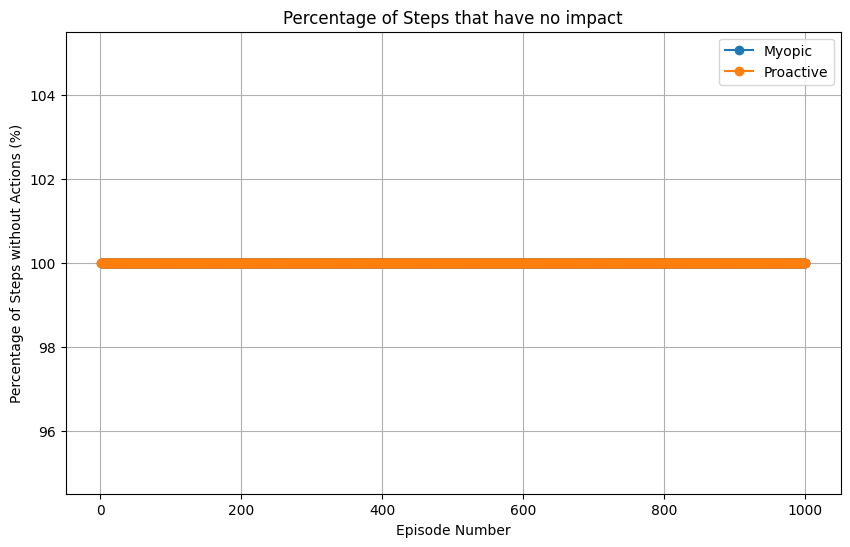

In [1]:
import json
import numpy as np
import glob
import os
import matplotlib.pyplot as plt

# Find the latest training id
files = glob.glob("../logs/training/training_*.json")
latest_file = max(files, key=lambda x: int(x.split('_')[-1].split('.')[0]))
latest_id = int(latest_file.split('_')[-1].split('.')[0])

# myopic is latest_id -1 and proactive is latest_id
myopic_id = latest_id - 1
proactive_id = latest_id

myopic_file_path = f"../logs/training/training_{myopic_id:04d}.json"
proactive_file_path = f"../logs/training/training_{proactive_id:04d}.json"

print(f"Myopic Training ID: {myopic_id}")
print(f"Proactive Training ID: {proactive_id}")

# Load data from both files
with open(myopic_file_path, 'r') as file:
    data_myopic = json.load(file)
with open(proactive_file_path, 'r') as file:
    data_proactive = json.load(file)

def calculate_episode_percentages(data):
    episode_percentages = []
    
    for episode_number in data['episodes']: 
        episode_data = data['episodes'][episode_number]
        
        # Counter for this episode
        total_steps = 0
        steps_without_action = 0
        
        for scenario_number in episode_data['scenarios']:
            scenario_data = episode_data['scenarios'][scenario_number]
            for step_number in range(len(scenario_data['steps'])):
                step_data = scenario_data['steps'][step_number]
                total_steps += 1
                if 'something_happened' not in step_data['info_after_step'] or step_data['info_after_step']['something_happened'] != 1:
                    steps_without_action += 1
        
        # Calculate percentage for this episode
        if total_steps > 0:
            percentage = (steps_without_action / total_steps) * 100
            episode_percentages.append(percentage)
    
    return episode_percentages

# Calculate percentages for both datasets
episode_percentages_myopic = calculate_episode_percentages(data_myopic)
episode_percentages_proactive = calculate_episode_percentages(data_proactive)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(episode_percentages_myopic) + 1), episode_percentages_myopic, marker='o', label='Myopic')
plt.plot(range(1, len(episode_percentages_proactive) + 1), episode_percentages_proactive, marker='o', label='Proactive')
plt.xlabel('Episode Number')
plt.ylabel('Percentage of Steps without Actions (%)')
plt.title('Percentage of Steps that have no impact')
plt.legend()
plt.grid(True)
plt.show()


# Reward distribution

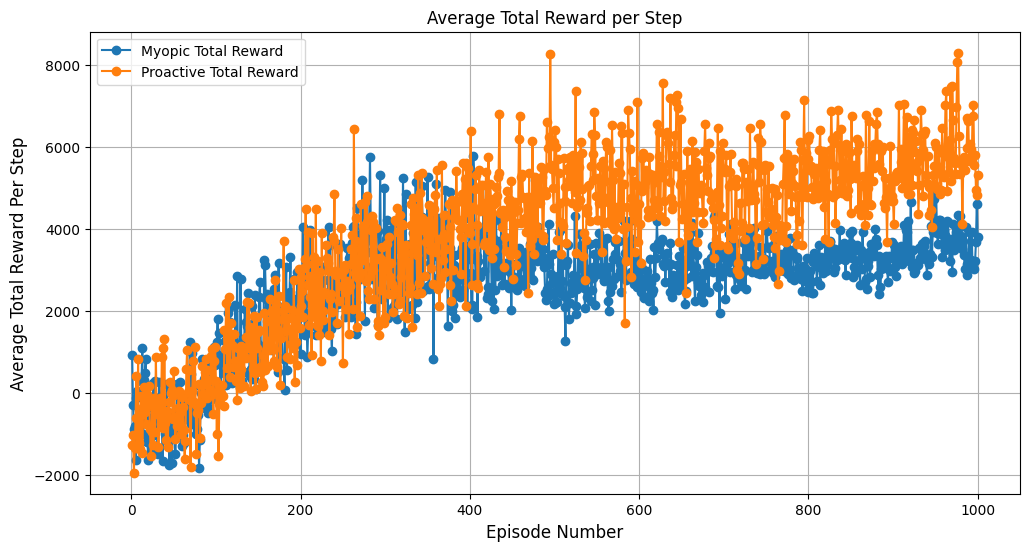

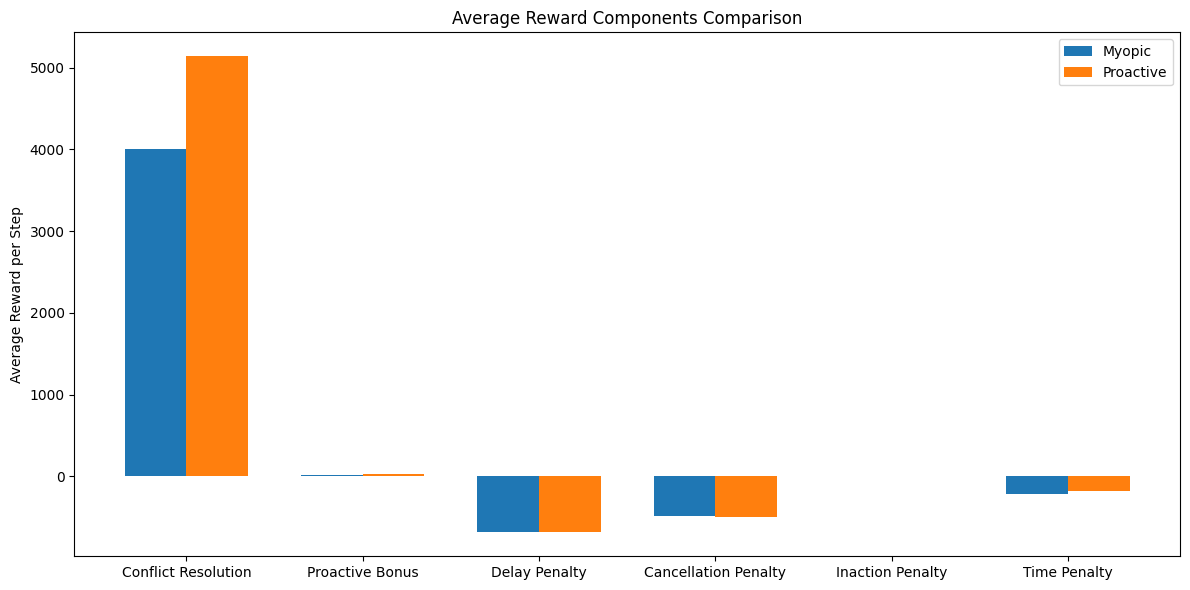

In [2]:
# %%
import matplotlib.pyplot as plt
import numpy as np

def calculate_rewards_per_step(data):
    rewards_total = []
    rewards_conflict_resolution = []
    rewards_delay = []
    rewards_cancelled = []
    rewards_inaction = []
    rewards_proactive = []
    rewards_time_progression = []
    
    for episode_number in data['episodes']:
        episode_data = data['episodes'][episode_number]
        
        # Initialize reward counters for this episode
        total_steps = 0
        episode_total = 0
        episode_conflict = 0
        episode_delay = 0
        episode_cancelled = 0
        episode_inaction = 0
        episode_proactive = 0
        episode_time = 0
        
        for scenario_number in episode_data['scenarios']:
            scenario_data = episode_data['scenarios'][scenario_number]
            steps = len(scenario_data['steps'])  # Total steps in the scenario
            total_steps += steps  # Add to total steps
            
            for step_data in scenario_data['steps']:
                info = step_data['info_after_step']
                
                # Sum up the different reward components
                episode_total += step_data['reward']
                episode_conflict += info.get('conflict_resolution_reward', 0)
                episode_delay -= info.get('delay_penalty_total', 0)  # Made negative
                episode_cancelled -= info.get('cancellation_penalty', 0)  # Made negative
                episode_inaction -= info.get('inaction_penalty', 0)  # Made negative
                episode_proactive += info.get('proactive_bonus', 0)
                episode_time -= info.get('time_penalty', 0)  # Made negative
        
        # Calculate average rewards per step
        if total_steps > 0:
            rewards_total.append(episode_total / total_steps)
            rewards_conflict_resolution.append(episode_conflict / total_steps)
            rewards_delay.append(episode_delay / total_steps)
            rewards_cancelled.append(episode_cancelled / total_steps)
            rewards_inaction.append(episode_inaction / total_steps)
            rewards_proactive.append(episode_proactive / total_steps)
            rewards_time_progression.append(episode_time / total_steps)
    
    return (rewards_total, rewards_conflict_resolution, rewards_delay, rewards_cancelled, rewards_inaction, rewards_proactive, rewards_time_progression)

# Calculate rewards for both datasets
(rewards_total_myopic, rewards_conflict_myopic, rewards_delay_myopic, rewards_cancelled_myopic, rewards_inaction_myopic, rewards_proactive_myopic, rewards_time_myopic) = calculate_rewards_per_step(data_myopic)

(rewards_total_proactive, rewards_conflict_proactive, rewards_delay_proactive, rewards_cancelled_proactive, rewards_inaction_proactive, rewards_proactive_proactive, rewards_time_proactive) = calculate_rewards_per_step(data_proactive)

# Plot the total average reward per step for both datasets
plt.figure(figsize=(12, 6))
x_myopic = range(1, len(rewards_total_myopic) +1)
x_proactive = range(1, len(rewards_total_proactive) +1)

plt.plot(x_myopic, rewards_total_myopic, label='Myopic Total Reward', marker='o')
plt.plot(x_proactive, rewards_total_proactive, label='Proactive Total Reward', marker='o')

plt.xlabel('Episode Number', fontsize=12)
plt.ylabel('Average Total Reward Per Step', fontsize=12)
plt.title('Average Total Reward per Step')
plt.legend()
plt.grid(True)
plt.show()

# Plot the reward components for both datasets
components = ['Conflict Resolution', 'Proactive Bonus', 'Delay Penalty', 'Cancellation Penalty', 'Inaction Penalty', 'Time Penalty']
colors = ['#2B8CBE', '#A6BDDB', '#E41A1C', '#984EA3', '#FF7F00', '#4DAF4A']

# Calculate averages over all episodes
avg_components_myopic = [
    np.mean(rewards_conflict_myopic),
    np.mean(rewards_proactive_myopic),
    np.mean(rewards_delay_myopic),
    np.mean(rewards_cancelled_myopic),
    np.mean(rewards_inaction_myopic),
    np.mean(rewards_time_myopic)
]

avg_components_proactive = [
    np.mean(rewards_conflict_proactive),
    np.mean(rewards_proactive_proactive),
    np.mean(rewards_delay_proactive),
    np.mean(rewards_cancelled_proactive),
    np.mean(rewards_inaction_proactive),
    np.mean(rewards_time_proactive)
]

x = np.arange(len(components))  # the label locations
bar_width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - bar_width/2, avg_components_myopic, bar_width, label='Myopic', color='#1f77b4')
rects2 = ax.bar(x + bar_width/2, avg_components_proactive, bar_width, label='Proactive', color='#ff7f0e')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Reward per Step')
ax.set_title('Average Reward Components Comparison')
ax.set_xticks(x)
ax.set_xticklabels(components)
ax.legend()

fig.tight_layout()
plt.show()


# Available actions for the agent per step

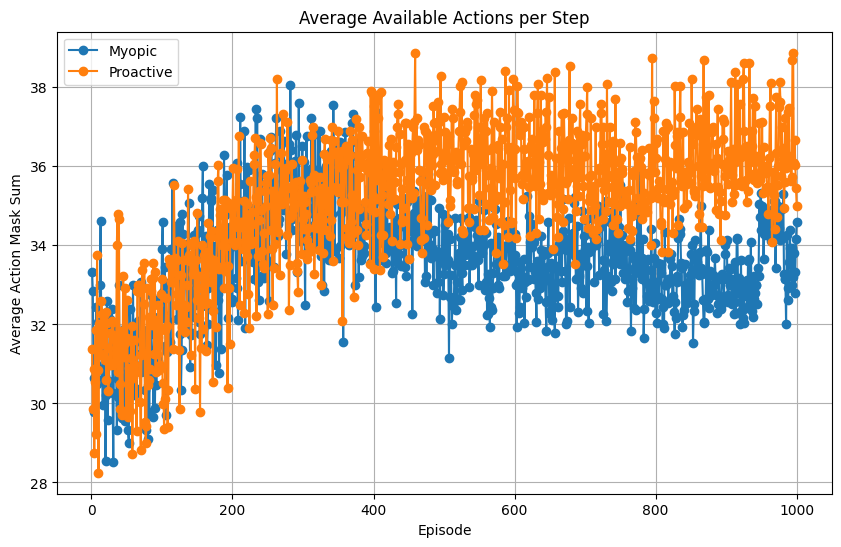

In [3]:
# %%
def calculate_average_available_actions(data):
    episode_action_sums = []
    episodes = []
    
    # Process data
    for episode_number in data['episodes']:
        episode_data = data['episodes'][episode_number]
        total_action_mask_sum = 0
        step_count = 0
    
        for scenario_number in episode_data['scenarios']:
            scenario_data = episode_data['scenarios'][scenario_number]
    
            for step_data in scenario_data['steps']:
                total_action_mask_sum += step_data['action_mask_sum']
                step_count += 1
        
        # Append average for the episode
        if step_count > 0:
            average_action_mask = total_action_mask_sum / step_count
            episode_action_sums.append(average_action_mask)
            episodes.append(int(episode_number))
    
    return episodes, episode_action_sums

# Calculate for both datasets
episodes_myopic, avg_actions_myopic = calculate_average_available_actions(data_myopic)
episodes_proactive, avg_actions_proactive = calculate_average_available_actions(data_proactive)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(episodes_myopic, avg_actions_myopic, marker='o', label='Myopic')
plt.plot(episodes_proactive, avg_actions_proactive, marker='o', label='Proactive')
plt.title('Average Available Actions per Step')
plt.xlabel('Episode')
plt.ylabel('Average Action Mask Sum')
plt.legend()
plt.grid(True)
plt.show()


# Steps to resolve a disrupted scenario

## Total

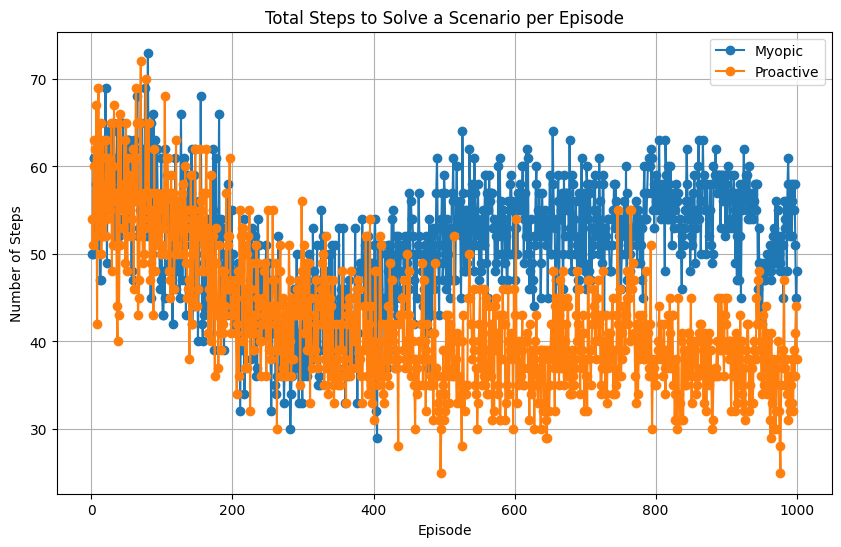

In [4]:
# %% [markdown]
# ## Total

# %%
def calculate_total_steps_per_episode(data):
    episode_step_counts = []
    episodes = []
    
    # Process data
    for episode_number in data['episodes']:
        episode_data = data['episodes'][episode_number]
        total_steps = 0
    
        for scenario_number in episode_data['scenarios']:
            scenario_data = episode_data['scenarios'][scenario_number]
            total_steps += len(scenario_data['steps'])
        
        episode_step_counts.append(total_steps)
        episodes.append(int(episode_number))
    
    return episodes, episode_step_counts

# Calculate for both datasets
episodes_myopic, steps_myopic = calculate_total_steps_per_episode(data_myopic)
episodes_proactive, steps_proactive = calculate_total_steps_per_episode(data_proactive)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(episodes_myopic, steps_myopic, marker='o', label='Myopic')
plt.plot(episodes_proactive, steps_proactive, marker='o', label='Proactive')
plt.title('Total Steps to Solve a Scenario per Episode')
plt.xlabel('Episode')
plt.ylabel('Number of Steps')
plt.legend()
plt.grid(True)
plt.show()


## Average per scenario

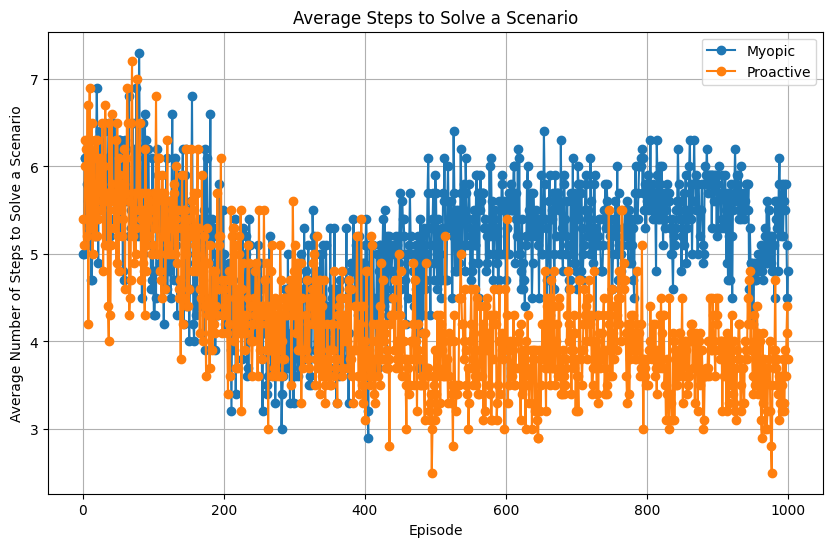

In [5]:
# %%
def calculate_avg_steps_per_scenario(data):
    episode_avg_step_counts = []
    episodes = []
    
    # Process data
    for episode_number in data['episodes']:
        episode_data = data['episodes'][episode_number]
        total_steps = 0
        num_scenarios = len(episode_data['scenarios'])
    
        for scenario_number in episode_data['scenarios']:
            scenario_data = episode_data['scenarios'][scenario_number]
            total_steps += len(scenario_data['steps'])
        
        # Calculate average steps per scenario
        avg_steps = total_steps / num_scenarios if num_scenarios > 0 else 0
        episode_avg_step_counts.append(avg_steps)
        episodes.append(int(episode_number))
    
    return episodes, episode_avg_step_counts

# Calculate for both datasets
episodes_myopic, avg_steps_myopic = calculate_avg_steps_per_scenario(data_myopic)
episodes_proactive, avg_steps_proactive = calculate_avg_steps_per_scenario(data_proactive)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(episodes_myopic, avg_steps_myopic, marker='o', label='Myopic')
plt.plot(episodes_proactive, avg_steps_proactive, marker='o', label='Proactive')
plt.title('Average Steps to Solve a Scenario')
plt.xlabel('Episode')
plt.ylabel('Average Number of Steps to Solve a Scenario')
plt.legend()
plt.grid(True)
plt.show()


# Proactive vs. Reactive actions chosen

## Categorized

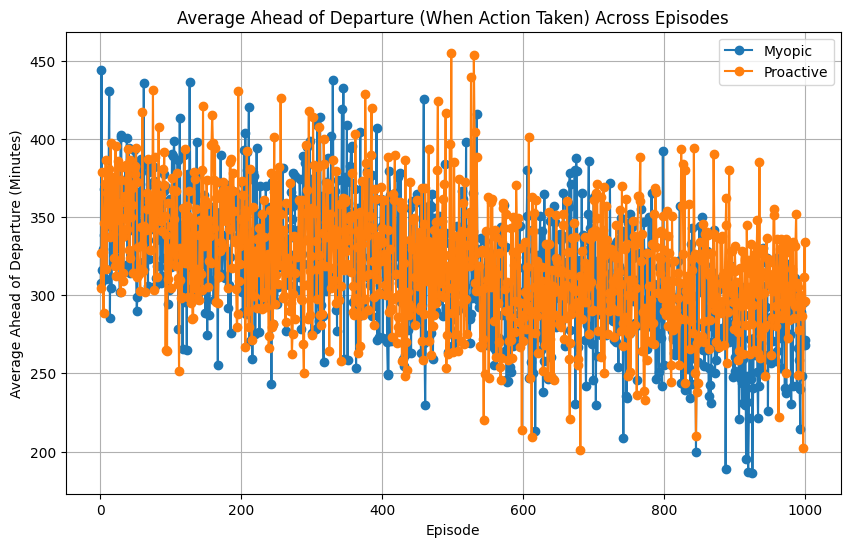

In [6]:
# %%
def calculate_avg_time_to_departure(data):
    episode_avg_time_to_departure = []
    episode_std_time_to_departure = []
    episodes = []
    
    # Iterate through episodes
    for episode_number, episode_data in data['episodes'].items():
        total_time_to_departure = 0
        time_to_departure_values = []
        total_steps_with_action = 0
        
        # Iterate through scenarios in episode
        for scenario_number in episode_data['scenarios']:
            scenario_data = episode_data['scenarios'][scenario_number]
            steps = scenario_data['steps']
            
            # Sum up time to departure for steps where something happened
            for step in steps:
                if step['info_after_step']['something_happened'] == 1:
                    ttd = step['info_after_step'].get('time_to_departure_minutes')
                    if isinstance(ttd, (int, float)):  # Only process numeric values
                        time_to_departure_values.append(ttd)
                        total_time_to_departure += ttd
                        total_steps_with_action += 1
        
        # Calculate average time to departure for the episode
        if total_steps_with_action > 0:
            avg_ttd = total_time_to_departure / total_steps_with_action
            std_dev = np.std(time_to_departure_values) if len(time_to_departure_values) > 1 else 0
            episode_avg_time_to_departure.append(avg_ttd)
            episode_std_time_to_departure.append(std_dev)
            episodes.append(int(episode_number))
    
    return episodes, episode_avg_time_to_departure, episode_std_time_to_departure

# Calculate for both datasets
episodes_myopic, avg_ttd_myopic, std_dev_myopic = calculate_avg_time_to_departure(data_myopic)
episodes_proactive, avg_ttd_proactive, std_dev_proactive = calculate_avg_time_to_departure(data_proactive)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(episodes_myopic, avg_ttd_myopic, label='Myopic', marker='o')
plt.plot(episodes_proactive, avg_ttd_proactive, label='Proactive', marker='o')
plt.title('Average Ahead of Departure (When Action Taken) Across Episodes')
plt.xlabel('Episode')
plt.ylabel('Average Ahead of Departure (Minutes)')
plt.legend()
plt.grid(True)
plt.show()


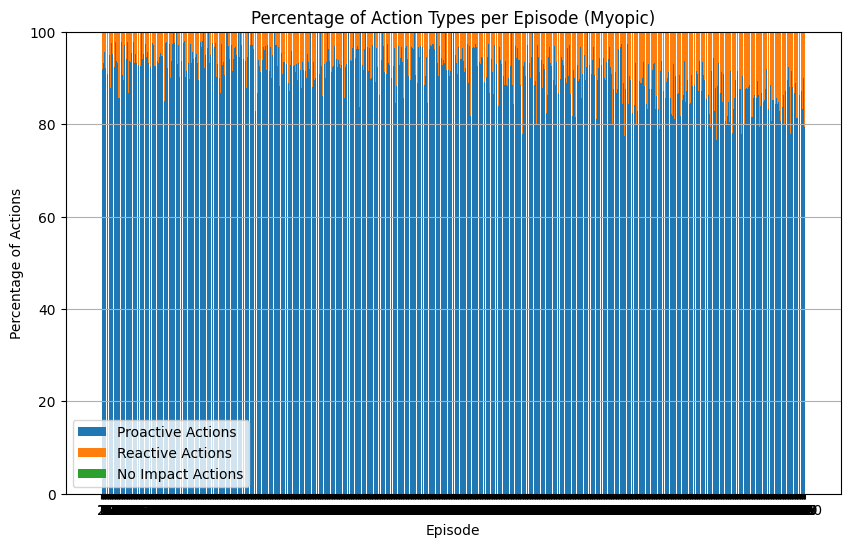

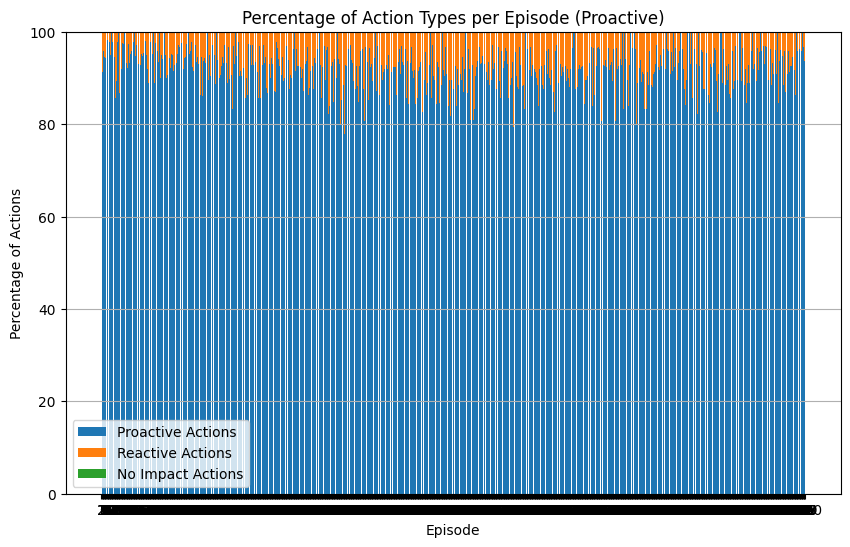

In [9]:

# %%
def calculate_action_types(data, threshold=30):
    # Initialize variables to store proactive and reactive counts per episode
    episode_proactive_counts = []
    episode_reactive_counts = []
    episode_no_impact_counts = []
    episodes = []
    
    # Process data
    for episode_number in data['episodes']:
        episode_data = data['episodes'][episode_number]
        proactive_count = 0
        reactive_count = 0
        no_impact_count = 0
    
        for scenario_number in episode_data['scenarios']:
            scenario_data = episode_data['scenarios'][scenario_number]
            
            for step in scenario_data['steps']:
                if step['info_after_step']['something_happened'] == 1:
                    time_to_departure = step['info_after_step'].get('time_to_departure_minutes')
                    if isinstance(time_to_departure, (int, float)):
                        if time_to_departure > threshold:
                            proactive_count += 1
                        else:
                            reactive_count += 1
                else:
                    no_impact_count += 1
        
        episode_proactive_counts.append(proactive_count)
        episode_reactive_counts.append(reactive_count)
        episode_no_impact_counts.append(no_impact_count)
        episodes.append(int(episode_number))
    
    return episodes, episode_proactive_counts, episode_reactive_counts, episode_no_impact_counts

# Calculate for both datasets
episodes_myopic, proactive_myopic, reactive_myopic, no_impact_myopic = calculate_action_types(data_myopic)
episodes_proactive, proactive_proactive, reactive_proactive, no_impact_proactive = calculate_action_types(data_proactive)

# Plot the data (Percentage Stacked Bar Chart)
def plot_stacked_bar(episodes, proactive_counts, reactive_counts, no_impact_counts, label):
    # Calculate total actions per episode
    total_actions = (
        np.array(proactive_counts) 
        + np.array(reactive_counts) 
        + np.array(no_impact_counts)
    )
    
    # Convert counts to percentages
    proactive_percentages = (np.array(proactive_counts) / total_actions) * 100
    reactive_percentages = (np.array(reactive_counts) / total_actions) * 100
    no_impact_percentages = (np.array(no_impact_counts) / total_actions) * 100
    
    # Create stacked bar plot
    plt.figure(figsize=(10, 6))
    x = np.arange(len(episodes))
    
    plt.bar(x, proactive_percentages, label='Proactive Actions')
    plt.bar(x, reactive_percentages, bottom=proactive_percentages, label='Reactive Actions')
    plt.bar(x, no_impact_percentages, 
            bottom=proactive_percentages + reactive_percentages, label='No Impact Actions')
    
    plt.title(f'Percentage of Action Types per Episode ({label})')
    plt.xlabel('Episode')
    plt.ylabel('Percentage of Actions')
    plt.xticks(x, episodes)
    plt.legend()
    plt.grid(True, axis='y')
    plt.show()

# Plot for Myopic
plot_stacked_bar(episodes_myopic, proactive_myopic, reactive_myopic, no_impact_myopic, 'Myopic')

# Plot for Proactive
plot_stacked_bar(episodes_proactive, proactive_proactive, reactive_proactive, no_impact_proactive, 'Proactive')


## Time ahead of departure for action

In [10]:
# %%
def calculate_avg_time_to_departure(data):
    episode_avg_time_to_departure = []
    episode_std_time_to_departure = []
    episodes = []

    # Iterate through episodes
    for episode_number, episode_data in data['episodes'].items():
        total_time_to_departure = 0
        time_to_departure_values = []
        total_steps_with_action = 0

        # Iterate through scenarios in episode
        for scenario_number in episode_data['scenarios']:
            scenario_data = episode_data['scenarios'][scenario_number]
            steps = scenario_data['steps']

            # Sum up time to departure for steps where something happened
            for step in steps:
                if step['info_after_step']['something_happened'] == 1:
                    # Check if time_to_departure_minutes is not "None" before processing
                    ttd = step['info_after_step'].get('time_to_departure_minutes')
                    if isinstance(ttd, (int, float)):  # Only process numeric values
                        time_to_departure_values.append(ttd)
                        total_time_to_departure += ttd
                        total_steps_with_action += 1

        # Calculate average time to departure for the episode
        if total_steps_with_action > 0:
            avg_ttd = total_time_to_departure / total_steps_with_action
            std_dev = np.std(time_to_departure_values) if len(time_to_departure_values) > 1 else 0
            episode_avg_time_to_departure.append(avg_ttd)
            episode_std_time_to_departure.append(std_dev)
            episodes.append(int(episode_number))

    return episodes, episode_avg_time_to_departure, episode_std_time_to_departure

# Calculate for both datasets
episodes_myopic, avg_ttd_myopic, std_dev_myopic = calculate_avg_time_to_departure(data_myopic)
episodes_proactive, avg_ttd_proactive, std_dev_proactive = calculate_avg_time_to_departure(data_proactive)

# Plot the data
plt.figure(figsize=(10, 6))
plt.errorbar(episodes_myopic, avg_ttd_myopic, yerr=std_dev_myopic, label='Myopic', fmt='-o', capsize=5)
plt.errorbar(episodes_proactive, avg_ttd_proactive, yerr=std_dev_proactive, label='Proactive', fmt='-s', capsize=5)
plt.title('Average Time to Departure (When Action Taken) Across Episodes')
plt.xlabel('Episode')
plt.ylabel('Average Time to Departure (Minutes)')
plt.grid(True)
plt.legend()
plt.show()


KeyError: 'something_happened'

# Impact of the last step on the total reward

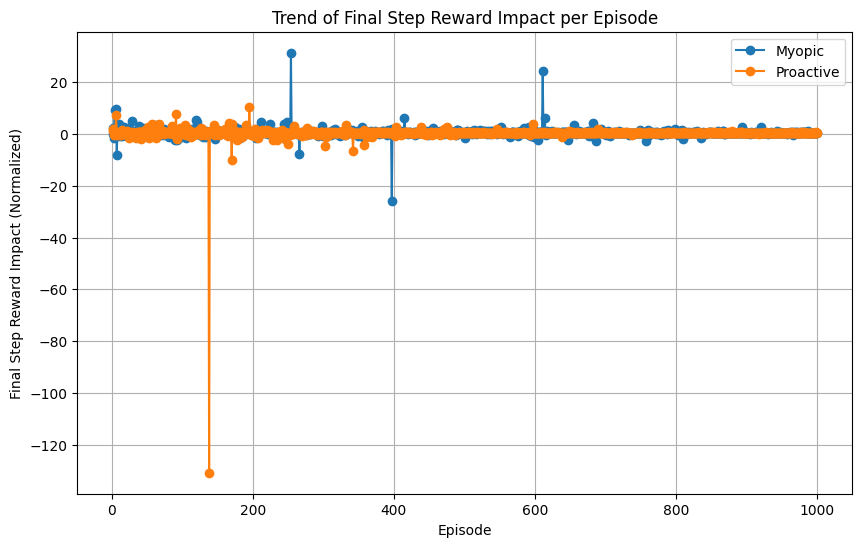

In [11]:
# %%
def calculate_final_step_impact(data):
    episode_final_step_impact = []
    episodes = []
    
    # Iterate through episodes
    for episode_number, episode_data in data['episodes'].items():
        total_final_step_impact = 0
        scenario_count = 0
        
        for scenario_number in episode_data['scenarios']:
            scenario_data = episode_data['scenarios'][scenario_number]
            steps = scenario_data['steps']
            
            if len(steps) > 0:
                # Get total reward from last step
                final_step = steps[-1]
                final_step_reward = final_step['reward']
                
                # Sum up rewards from all steps
                total_reward = sum(step['reward'] for step in steps)
                
                # Calculate normalized contribution of final step to total reward
                if total_reward != 0:  # Avoid division by zero
                    final_step_impact = final_step_reward / total_reward
                    total_final_step_impact += final_step_impact
                    scenario_count += 1
        
        # Calculate average final step impact for the episode
        if scenario_count > 0:
            avg_final_step_impact = total_final_step_impact / scenario_count
            episode_final_step_impact.append(avg_final_step_impact)
            episodes.append(int(episode_number))
        else:
            episode_final_step_impact.append(0)
            episodes.append(int(episode_number))
    
    return episodes, episode_final_step_impact

# Calculate for both datasets
episodes_myopic, final_step_impact_myopic = calculate_final_step_impact(data_myopic)
episodes_proactive, final_step_impact_proactive = calculate_final_step_impact(data_proactive)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(episodes_myopic, final_step_impact_myopic, label='Myopic', marker='o')
plt.plot(episodes_proactive, final_step_impact_proactive, label='Proactive', marker='o')
plt.title('Trend of Final Step Reward Impact per Episode')
plt.xlabel('Episode')
plt.ylabel('Final Step Reward Impact (Normalized)')
plt.legend()
plt.grid(True)
plt.show()


# Delay length disribution - average per step

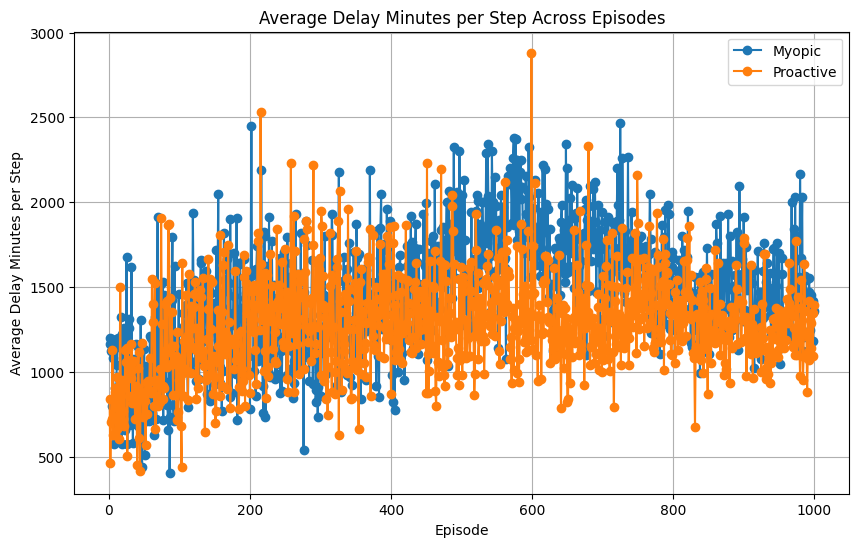

In [12]:
# %%
def calculate_avg_delay_per_step(data):
    episode_avg_delay_minutes = []
    episodes = []
    episode_std_dev = []  # To store standard deviation for each episode
    
    # Iterate through episodes
    for episode_number, episode_data in data['episodes'].items():
        total_delay_minutes = 0
        total_steps = 0
        delay_values = []  # To calculate standard deviation
        
        # Iterate through scenarios in episode
        for scenario_number in episode_data['scenarios']:
            scenario_data = episode_data['scenarios'][scenario_number]
            steps = scenario_data['steps']
            
            # Sum up delay minutes from all steps
            for step in steps:
                delay = step['info_after_step']['delay_penalty_minutes']
                delay_values.append(delay)
                total_delay_minutes += delay
                total_steps += 1
        
        # Calculate average delay minutes for the episode
        if total_steps > 0:
            avg_delay = total_delay_minutes / total_steps
            std_dev = np.std(delay_values)  # Calculate standard deviation
            episode_avg_delay_minutes.append(avg_delay)
            episodes.append(int(episode_number))
            episode_std_dev.append(std_dev)
        else:
            episode_avg_delay_minutes.append(0)
            episode_std_dev.append(0)
    
    return episodes, episode_avg_delay_minutes, episode_std_dev

# Calculate for both datasets
episodes_myopic, avg_delay_myopic, std_dev_myopic = calculate_avg_delay_per_step(data_myopic)
episodes_proactive, avg_delay_proactive, std_dev_proactive = calculate_avg_delay_per_step(data_proactive)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(episodes_myopic, avg_delay_myopic, label='Myopic', marker='o')
plt.plot(episodes_proactive, avg_delay_proactive, label='Proactive', marker='o')
plt.title('Average Delay Minutes per Step Across Episodes')
plt.xlabel('Episode')
plt.ylabel('Average Delay Minutes per Step')
plt.legend()
plt.grid(True)
plt.show()


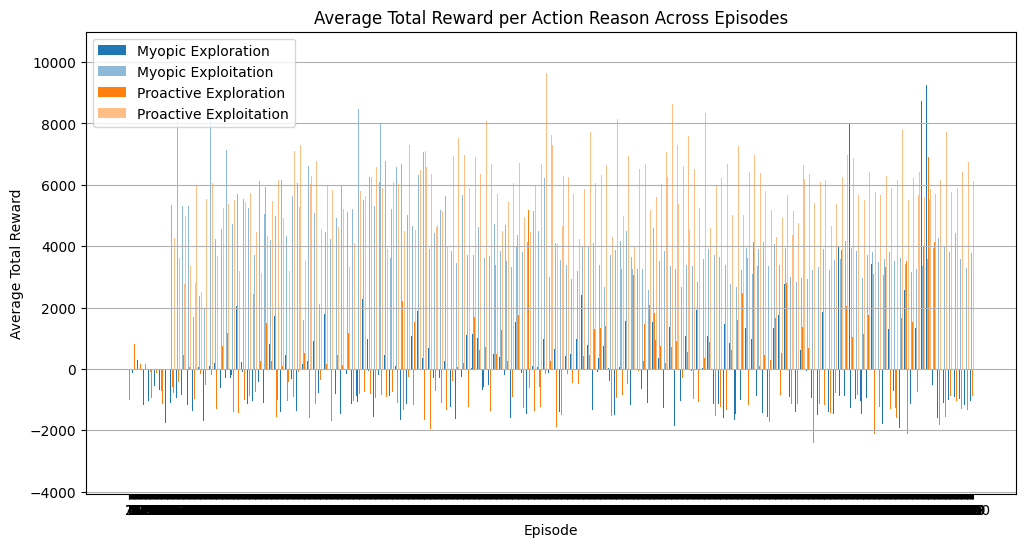

In [13]:
# %%
def calculate_rewards_by_action_reason(data):
    episode_rewards_exploration = []
    episode_rewards_exploitation = []
    episodes = []

    # Iterate through episodes to collect total rewards and action reasons
    for episode_number, episode_data in data['episodes'].items():
        total_rewards_exploration = []
        total_rewards_exploitation = []
        
        for scenario_number, scenario_data in episode_data['scenarios'].items():
            steps = scenario_data['steps']
            
            for step in steps:
                total_reward = step['info_after_step'].get('total_reward', 0)
                action_reason = step.get('action_reason')  # Assuming this field exists
                
                if action_reason == 'exploration':
                    total_rewards_exploration.append(total_reward)
                elif action_reason == 'exploitation':
                    total_rewards_exploitation.append(total_reward)

        # Calculate average total reward per action reason for the episode
        reward_exploration = np.mean(total_rewards_exploration) if total_rewards_exploration else 0
        reward_exploitation = np.mean(total_rewards_exploitation) if total_rewards_exploitation else 0

        episode_rewards_exploration.append(reward_exploration)
        episode_rewards_exploitation.append(reward_exploitation)
        episodes.append(int(episode_number))

    return episodes, episode_rewards_exploration, episode_rewards_exploitation

# Calculate for both datasets
episodes_myopic, rewards_exploration_myopic, rewards_exploitation_myopic = calculate_rewards_by_action_reason(data_myopic)
episodes_proactive, rewards_exploration_proactive, rewards_exploitation_proactive = calculate_rewards_by_action_reason(data_proactive)

# Align episodes for plotting
common_episodes = sorted(set(episodes_myopic).intersection(episodes_proactive))
indices_myopic = [episodes_myopic.index(ep) for ep in common_episodes]
indices_proactive = [episodes_proactive.index(ep) for ep in common_episodes]

rewards_exploration_myopic = [rewards_exploration_myopic[i] for i in indices_myopic]
rewards_exploitation_myopic = [rewards_exploitation_myopic[i] for i in indices_myopic]
rewards_exploration_proactive = [rewards_exploration_proactive[i] for i in indices_proactive]
rewards_exploitation_proactive = [rewards_exploitation_proactive[i] for i in indices_proactive]

# Create the bar plot
bar_width = 0.2
x = np.arange(len(common_episodes))

plt.figure(figsize=(12, 6))

plt.bar(x - bar_width*1.5, rewards_exploration_myopic, width=bar_width, label='Myopic Exploration', color='C0', alpha=1)
plt.bar(x - bar_width*0.5, rewards_exploitation_myopic, width=bar_width, label='Myopic Exploitation', color='C0', alpha=0.5)
plt.bar(x + bar_width*0.5, rewards_exploration_proactive, width=bar_width, label='Proactive Exploration', color='C1', alpha=1)
plt.bar(x + bar_width*1.5, rewards_exploitation_proactive, width=bar_width, label='Proactive Exploitation', color='C1', alpha=0.5)

plt.title('Average Total Reward per Action Reason Across Episodes')
plt.xlabel('Episode')
plt.ylabel('Average Total Reward')
plt.xticks(x, common_episodes)
plt.legend()
plt.grid(axis='y')
plt.show()


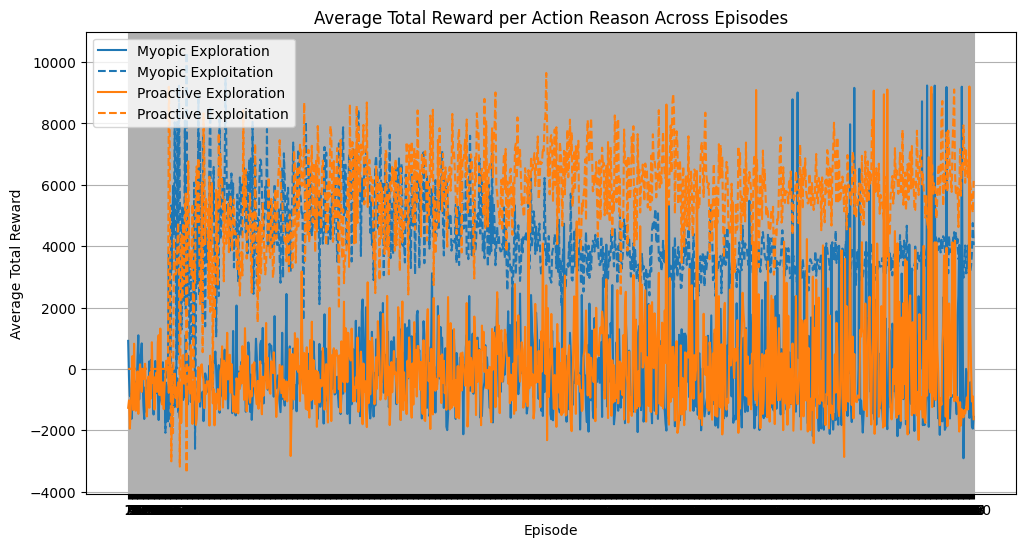

In [15]:
# %%
def calculate_rewards_by_action_reason(data):
    episode_rewards_exploration = []
    episode_rewards_exploitation = []
    episodes = []

    # Iterate through episodes to collect total rewards and action reasons
    for episode_number, episode_data in data['episodes'].items():
        total_rewards_exploration = []
        total_rewards_exploitation = []
        
        for scenario_number, scenario_data in episode_data['scenarios'].items():
            steps = scenario_data['steps']
            
            for step in steps:
                total_reward = step['info_after_step'].get('total_reward', 0)
                action_reason = step.get('action_reason')  # Assuming this field exists
                
                if action_reason == 'exploration':
                    total_rewards_exploration.append(total_reward)
                elif action_reason == 'exploitation':
                    total_rewards_exploitation.append(total_reward)

        # Calculate average total reward per action reason for the episode
        reward_exploration = np.mean(total_rewards_exploration) if total_rewards_exploration else 0
        reward_exploitation = np.mean(total_rewards_exploitation) if total_rewards_exploitation else 0

        episode_rewards_exploration.append(reward_exploration)
        episode_rewards_exploitation.append(reward_exploitation)
        episodes.append(int(episode_number))

    return episodes, episode_rewards_exploration, episode_rewards_exploitation

# Calculate for both datasets
episodes_myopic, rewards_exploration_myopic, rewards_exploitation_myopic = calculate_rewards_by_action_reason(data_myopic)
episodes_proactive, rewards_exploration_proactive, rewards_exploitation_proactive = calculate_rewards_by_action_reason(data_proactive)

# Align episodes for plotting
common_episodes = sorted(set(episodes_myopic).intersection(episodes_proactive))
indices_myopic = [episodes_myopic.index(ep) for ep in common_episodes]
indices_proactive = [episodes_proactive.index(ep) for ep in common_episodes]

rewards_exploration_myopic = [rewards_exploration_myopic[i] for i in indices_myopic]
rewards_exploitation_myopic = [rewards_exploitation_myopic[i] for i in indices_myopic]
rewards_exploration_proactive = [rewards_exploration_proactive[i] for i in indices_proactive]
rewards_exploitation_proactive = [rewards_exploitation_proactive[i] for i in indices_proactive]

# Create the line plot
plt.figure(figsize=(12, 6))
plt.plot(common_episodes, rewards_exploration_myopic, label='Myopic Exploration', color='C0')
plt.plot(common_episodes, rewards_exploitation_myopic, label='Myopic Exploitation', color='C0', linestyle='--')
plt.plot(common_episodes, rewards_exploration_proactive, label='Proactive Exploration', color='C1')
plt.plot(common_episodes, rewards_exploitation_proactive, label='Proactive Exploitation', color='C1', linestyle='--')

plt.title('Average Total Reward per Action Reason Across Episodes')
plt.xlabel('Episode')
plt.ylabel('Average Total Reward')
plt.xticks(common_episodes)
plt.legend()
plt.grid()
plt.show()
